In [1]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt

"""
PROBLEM: Attention is permutation-invariant!

"The cat sat" and "sat cat the" look identical to attention.
We need to tell the model WHERE each word is in the sequence.

SOLUTION: Add positional information to embeddings.
"""

# Demonstrate the problem
x1 = torch.tensor([[1, 2, 3]])  # "The cat sat"
x2 = torch.tensor([[3, 2, 1]])  # "sat cat The"

# Without position info, transformer treats these the same
print("Without positional encoding:")
print(f"Sequence 1: {x1}")
print(f"Sequence 2: {x2}")
print("Transformer can't tell the difference!\n")
print("✅ Problem understood")

Without positional encoding:
Sequence 1: tensor([[1, 2, 3]])
Sequence 2: tensor([[3, 2, 1]])
Transformer can't tell the difference!

✅ Problem understood


In [2]:
class PositionalEncoding(nn.Module):
    """
    Adds position information using sin/cos functions
    
    PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
    PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
    
    Why sin/cos? They allow the model to learn relative positions.
    """
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        
        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        
        # Compute the div_term for sin and cos
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * 
            -(math.log(10000.0) / d_model)
        )
        
        # Apply sin to even indices
        pe[:, 0::2] = torch.sin(position * div_term)
        
        # Apply cos to odd indices
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Add batch dimension
        pe = pe.unsqueeze(0)
        
        # Register as buffer (not a parameter, but part of state)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        """
        x: [batch, seq_len, d_model]
        """
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]

# Test
d_model = 512
pos_enc = PositionalEncoding(d_model, max_len=100)

x = torch.randn(2, 10, d_model)
output = pos_enc(x)

print(f"Input: {x.shape}")
print(f"Output: {output.shape}")
print("✅ Positional encoding working")

Input: torch.Size([2, 10, 512])
Output: torch.Size([2, 10, 512])
✅ Positional encoding working


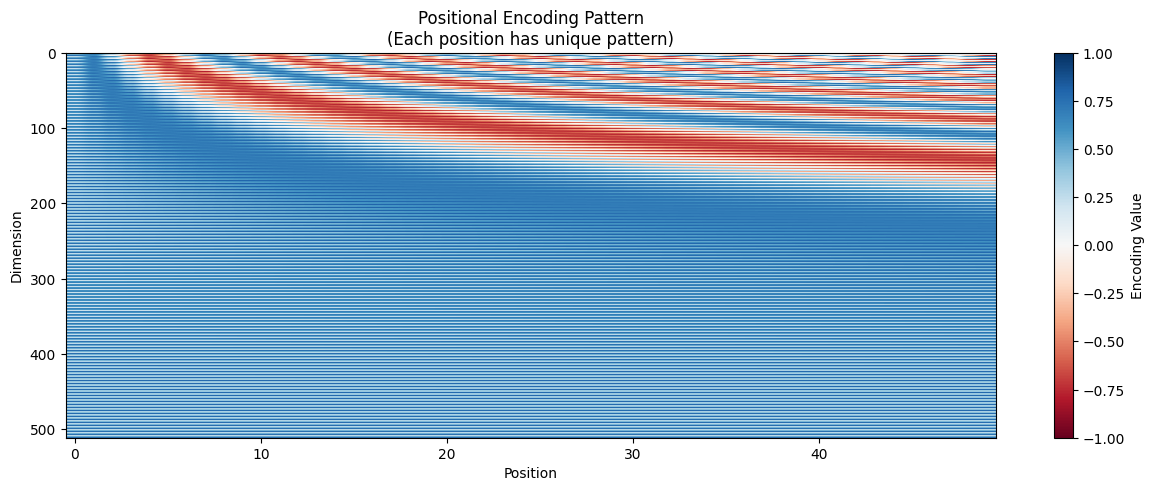

Pattern shows:
- Each position has unique encoding
- Lower dimensions change slowly
- Higher dimensions change quickly
✅ Visualization saved


In [3]:
# Visualize the encoding pattern
plt.figure(figsize=(15, 5))

pe_matrix = pos_enc.pe[0, :50, :].numpy()  # First 50 positions

plt.imshow(pe_matrix.T, cmap='RdBu', aspect='auto')
plt.colorbar(label='Encoding Value')
plt.xlabel('Position')
plt.ylabel('Dimension')
plt.title('Positional Encoding Pattern\n(Each position has unique pattern)')
plt.savefig('positional_encoding.png')
plt.show()

print("Pattern shows:")
print("- Each position has unique encoding")
print("- Lower dimensions change slowly")
print("- Higher dimensions change quickly")
print("✅ Visualization saved")

In [4]:
class TokenEmbedding(nn.Module):
    """
    Converts token IDs to dense vectors
    Also scales by sqrt(d_model) as in original paper
    """
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.d_model = d_model
        
    def forward(self, x):
        """
        x: [batch, seq_len] - token indices
        returns: [batch, seq_len, d_model]
        """
        return self.embedding(x) * math.sqrt(self.d_model)

# Test
vocab_size = 10000
token_emb = TokenEmbedding(vocab_size, d_model)

# Simulate token IDs
tokens = torch.randint(0, vocab_size, (2, 10))
embeddings = token_emb(tokens)

print(f"Token IDs: {tokens.shape}")
print(f"Embeddings: {embeddings.shape}")
print(f"Vocabulary size: {vocab_size}")
print("✅ Token embedding working")

Token IDs: torch.Size([2, 10])
Embeddings: torch.Size([2, 10, 512])
Vocabulary size: 10000
✅ Token embedding working


In [5]:
class TransformerInputLayer(nn.Module):
    """
    Complete input processing:
    1. Token embedding
    2. Positional encoding
    3. Dropout
    """
    def __init__(self, vocab_size, d_model, max_len=5000, dropout=0.1):
        super().__init__()
        self.token_embedding = TokenEmbedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        """
        x: [batch, seq_len] - token indices
        returns: [batch, seq_len, d_model]
        """
        x = self.token_embedding(x)
        x = self.positional_encoding(x)
        x = self.dropout(x)
        return x

# Test
input_layer = TransformerInputLayer(vocab_size=10000, d_model=512)
tokens = torch.randint(0, 10000, (2, 20))
processed = input_layer(tokens)

print(f"Input tokens: {tokens.shape}")
print(f"Processed embeddings: {processed.shape}")
print(f"Parameters: {sum(p.numel() for p in input_layer.parameters()):,}")
print("✅ Complete input layer working")

Input tokens: torch.Size([2, 20])
Processed embeddings: torch.Size([2, 20, 512])
Parameters: 5,120,000
✅ Complete input layer working


In [7]:
# Show why positional encoding matters
tokens_forward = torch.tensor([[1, 2, 3, 4, 5]])
tokens_reversed = torch.tensor([[5, 4, 3, 2, 1]])

# Without positional encoding
token_only = TokenEmbedding(vocab_size=10, d_model=64)
embed_fwd = token_only(tokens_forward)
embed_rev = token_only(tokens_reversed)

# With positional encoding
input_with_pos = TransformerInputLayer(vocab_size=10, d_model=64)
embed_fwd_pos = input_with_pos(tokens_forward)
embed_rev_pos = input_with_pos(tokens_reversed)

# Compare similarity
sim_without = F.cosine_similarity(
    embed_fwd.mean(dim=1), 
    embed_rev.mean(dim=1)
).item()

sim_with = F.cosine_similarity(
    embed_fwd_pos.mean(dim=1), 
    embed_rev_pos.mean(dim=1)
).item()

print("Forward sequence: [1, 2, 3, 4, 5]")
print("Reverse sequence: [5, 4, 3, 2, 1]")
print(f"\nSimilarity WITHOUT positional encoding: {sim_without:.4f}")
print(f"Similarity WITH positional encoding: {sim_with:.4f}")
print("\nWith positional encoding, model can distinguish order!")
print("✅ Positional encoding makes a difference")

NameError: name 'F' is not defined

In [ ]:
# Show why positional encoding matters
tokens_forward = torch.tensor([[1, 2, 3, 4, 5]])
tokens_reversed = torch.tensor([[5, 4, 3, 2, 1]])

# Without positional encoding
token_only = TokenEmbedding(vocab_size=10, d_model=64)
embed_fwd = token_only(tokens_forward)
embed_rev = token_only(tokens_reversed)

# With positional encoding
input_with_pos = TransformerInputLayer(vocab_size=10, d_model=64)
embed_fwd_pos = input_with_pos(tokens_forward)
embed_rev_pos = input_with_pos(tokens_reversed)

# Compare similarity
sim_without = F.cosine_similarity(
    embed_fwd.mean(dim=1), 
    embed_rev.mean(dim=1)
).item()

sim_with = F.cosine_similarity(
    embed_fwd_pos.mean(dim=1), 
    embed_rev_pos.mean(dim=1)
).item()

print("Forward sequence: [1, 2, 3, 4, 5]")
print("Reverse sequence: [5, 4, 3, 2, 1]")
print(f"\nSimilarity WITHOUT positional encoding: {sim_without:.4f}")
print(f"Similarity WITH positional encoding: {sim_with:.4f}")
print("\nWith positional encoding, model can distinguish order!")
print("✅ Positional encoding makes a difference")